# Experimento 2

Jeffrey Leiva Cascante 2021016720

Richard León Chinchilla 2019003759


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: r29leonc (iaredescnncnn-instituto-tecnol-gico-de-costa-rica). Use `wandb login --relogin` to force relogin
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | encoder | Sequential | 19.8 M | train
1 | decoder | Sequential | 19.8 M | train
-----------------------------------------------
39.6 M    Trainable params
0         Non-trainable params
39.6 M    Total params
158.472   Total estimated model params size (MB)
27        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\richa\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:419: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
c:\Users\richa\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:419: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
c:\Users\richa\anaconda3\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:298: The number of training batches (40) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


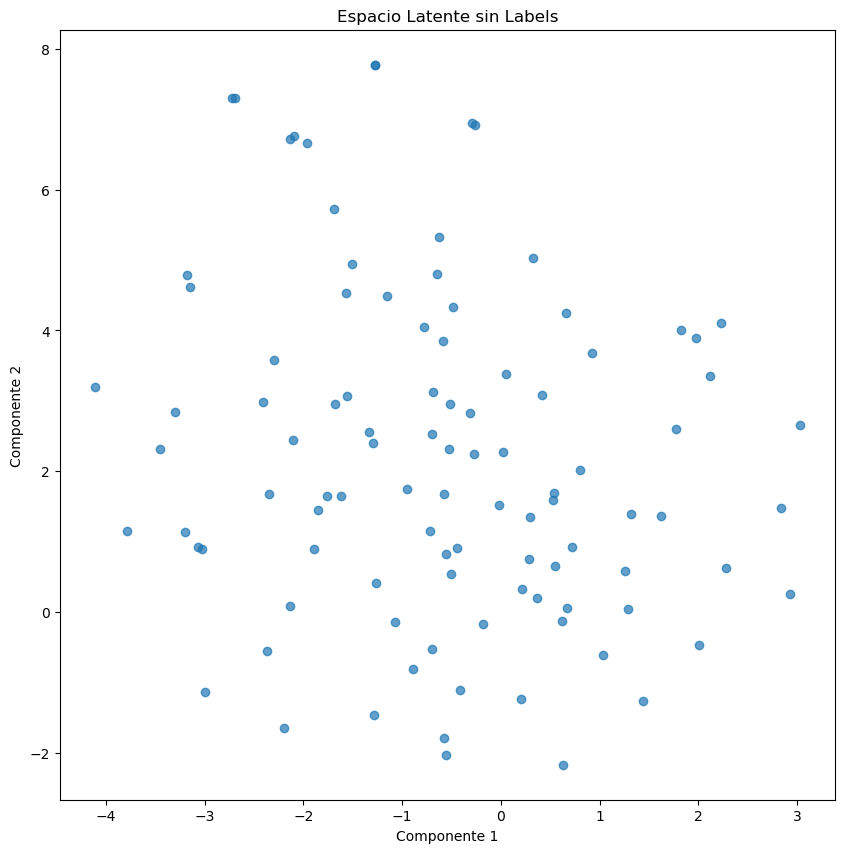

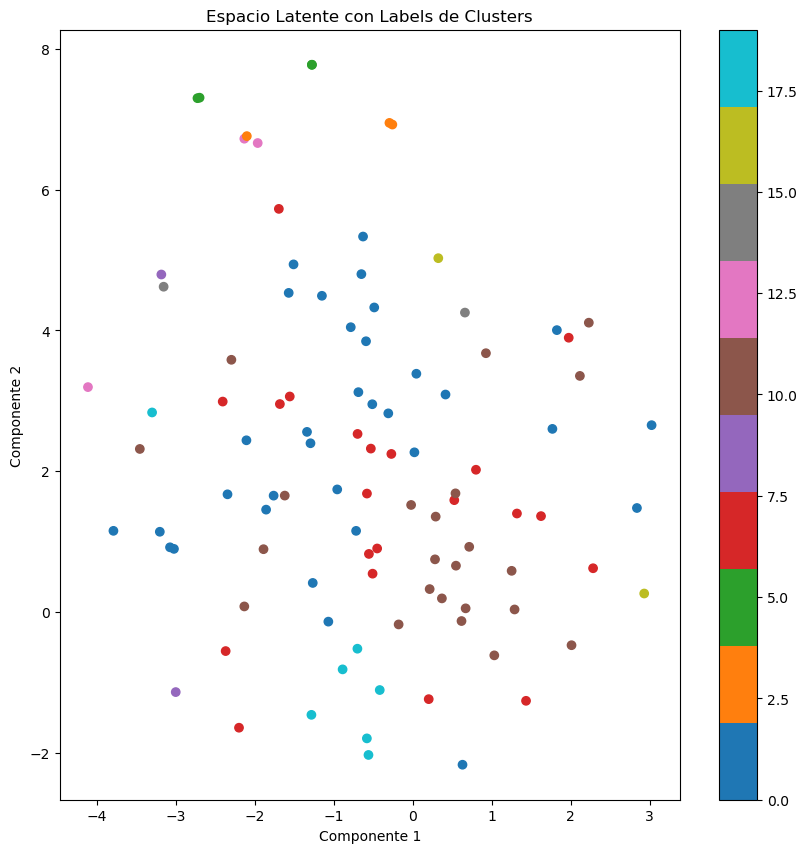

ARI: 0.08847184986595175


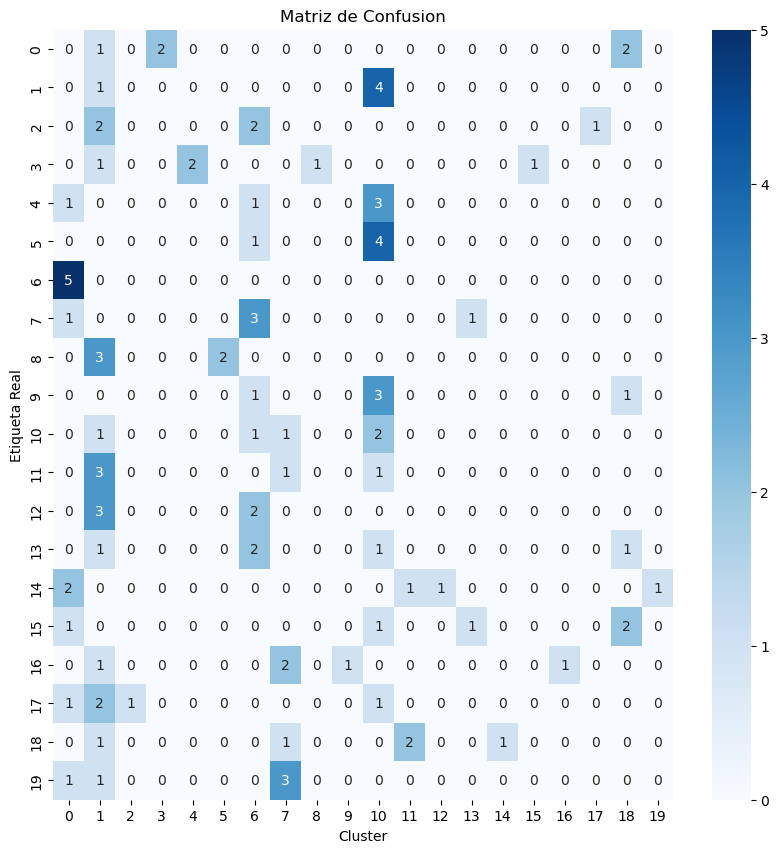

epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█▇▆▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▆▆▆▆▆▆▇▇▇▇▇████
val_loss,█▇▆▅▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,29
train_loss,0.01847
trainer/global_step,1199
val_loss,0.0201


In [1]:
import sys
import os
import hydra
from Config.config import Configuration
from DenoisingAutoencoder import DenoisingAutoEncoder
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets
import pytorch_lightning as L
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.loggers import WandbLogger
from DataModule import ButterflyDataModule
import wandb
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import io
from sklearn.cluster import KMeans
from threadpoolctl import threadpool_limits
from PIL import Image
from sklearn.metrics import adjusted_rand_score, confusion_matrix
import pandas as pd
import seaborn as sns

wandb.login()

notebook_dir = os.path.dirname(os.path.abspath(os.getcwd()))
config_dir = os.path.join(notebook_dir, 'proyecto-transfer-learning\\Config')

sys.argv = [arg for arg in sys.argv if not arg.startswith("--")]

@hydra.main(config_path=config_dir, config_name="config", version_base=None)
def trainining_denoising_autoencoder(config: Configuration):
    data_module = ButterflyDataModule(config.DATASET.DATA_DIR,config.TRAIN.BATCH_SIZE, False, 0,
                                      config.TRAIN.NUM_WORKERS)
    data_module.setup()


    model = DenoisingAutoEncoder(config.MODEL.LATENT_DIM,config.TRAIN.LEARNING_RATE)

    early_stop_callback = EarlyStopping(
        monitor='val_loss',
        patience=3,
        verbose=False,
        mode='min'
    )

    wandb_logger = WandbLogger(
        project="Denoising-Autoencoder",
        log_model=True,
    )

    trainer = L.Trainer(
        max_epochs=config.TRAIN.NUM_EPOCHS,
        accelerator=config.TRAIN.ACCELERATION,
        precision=config.TRAIN.PRECISION,
        callbacks=[early_stop_callback],
        logger=wandb_logger,
        devices=1 if torch.cuda.is_available() else None
    )


    trainer.fit(model, data_module)

    #Extraer los vectores latentes
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()
    latent_vectors,true_labels = extract_latent_vectors(model,data_module.val_dataloader(),device)
   

    #Convertir los tensores a numpy arrays
    latent_vectors_np = latent_vectors.cpu().numpy()

    #Aplicar t-SNE
    tsne = TSNE(n_components=2, random_state=0)
    with threadpool_limits(limits=1):
        latent_2d = tsne.fit_transform(latent_vectors_np)

    #Visualizar el espacio latente
    plot_latent_space(latent_2d, title="Espacio Latente sin Labels", logger=wandb_logger)
    

    #Aplicar K-means
    n_clusters = 20 #Numero de clases
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(latent_vectors_np)

    #Visualizar el espacio latente con las etiquetas de los clusters
    plot_latent_space(latent_2d,cluster_labels,"Espacio Latente con Labels de Clusters",logger=wandb_logger)

    ari = adjusted_rand_score(true_labels, cluster_labels)
    print(f"ARI: {ari}")

    #Matriz de confusion
    cm = confusion_matrix(true_labels, cluster_labels)
    cm_df = pd.DataFrame(cm, index=np.unique(true_labels), columns=np.unique(cluster_labels))
    plt.figure(figsize=(10,10))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.title("Matriz de Confusion")
    plt.xlabel("Cluster")
    plt.ylabel("Etiqueta Real")
    plt.show()
    #Finalizar el experimento de wandb

    wandb_logger.experiment.finish()

# Funcion para extraer los vectores latentes
def extract_latent_vectors(model, dataloader, device):
    latent_vectors = []
    labels = []
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            z = model.encode(x)
            latent_vectors.append(z.cpu())
            labels.append(y)
    latent_vectors = torch.cat(latent_vectors)
    labels = torch.cat(labels)
    return latent_vectors, labels.cpu().numpy()


def plot_latent_space(latent_2d, labels=None, title="Espacio Latente", logger=None):
    plt.figure(figsize=(10,10))
    if labels is not None:
        scatter = plt.scatter(latent_2d[:,0], latent_2d[:,1], c=labels, cmap='tab10')
        plt.colorbar(scatter)
    else:
        plt.scatter(latent_2d[:,0], latent_2d[:,1], alpha=0.7)
    plt.title(title)
    plt.xlabel("Componente 1")
    plt.ylabel("Componente 2")
    plt.show()
    plt.close()



    

trainining_denoising_autoencoder()
        
        